# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction


### Designing and training a CNN from scratch



In [ ]:
from io import BytesIO
import urllib.request
from zipfile import ZipFile
import os
import torch
import torch.utils.data
from torchvision import datasets, transforms
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt
import concurrent.futures

# Let's see if we have an available GPU
import numpy as np
import random

In [ ]:
# This project was run on GPUs. CNN training runs below ran for 3-4 hours with GPU (Tesla T4 16GBRAM)
use_cuda = torch.cuda.is_available()

In [ ]:
# download dataset
from src.helpers import download_and_extract
download_and_extract()

### Normalization of Input data
Images are made of pixels which together make up the whole picture. Each pixel is a combination of 3 channels representing the strength of Red, Green and Blue colors - combination of which produces the required color. Normalization of these pixel values per channel is essential in image classification to ensure all pixel values have a consistent scale which improves model performance. We have to calculate and process each channel independently.

To normalize, we compute the per-channel mean and standard deviation and then we can standardize pixel values.

In [ ]:
from src.helpers import get_data_location

def compute_mean_and_std():
    """
    Compute per-channel (R,G,B channels) mean and std of the dataset (to be used in transforms.Normalize())
    """

    # Check for cached results and use if previously estimated and saved
    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    # Fetch image folder location and load to Tensor and then PyTorch DataLoader
    folder = get_data_location()
    ds = datasets.ImageFolder(
        folder, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=0
    )

    # Iterate over the images and calculate the mean across all pixels for each channel (R, G, B)
    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    # Iterate and calculate the variance and then std
    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std

compute_mean_and_std()

### Visualize a Batch of Training Data

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


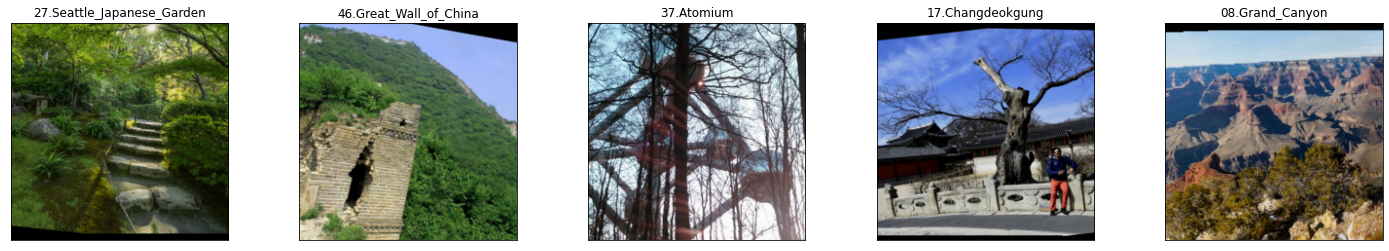

In [5]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=0 (all CPUs)
data_loaders = get_data_loaders(batch_size = 5, valid_size = 0.01, num_workers = 0) # YOUR CODE HERE

visualize_one_batch(data_loaders)

## Training Model

In [4]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation

num_classes = 50       # number of classes. Do not change this
dropout = 0.2          # dropout for our model

learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = "sgd"            # optimizer. 'sgd' or 'adam'
weight_decay = 0.01     # regularization. Increase this to combat overfitting

num_epochs = 100        # number of epochs for training

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


Training: 100%|███████████████████████████████| 125/125 [04:13<00:00,  2.03s/it]

Training Accuracy: 2.85%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.04it/s]


Epoch: 1 	Training Loss: 3.898846 	Validation Loss: 3.853436 	Training Accuracy: 2.85% 	Validation Accuracy: 5.30%
New minimum validation loss: 3.853436. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 6.58%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]


Epoch: 2 	Training Loss: 3.785485 	Validation Loss: 3.644374 	Training Accuracy: 6.58% 	Validation Accuracy: 9.10%
New minimum validation loss: 3.644374. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 9.68%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]


Epoch: 3 	Training Loss: 3.575696 	Validation Loss: 3.460261 	Training Accuracy: 9.68% 	Validation Accuracy: 13.70%
New minimum validation loss: 3.460261. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 11.71%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.18it/s]


Epoch: 4 	Training Loss: 3.460688 	Validation Loss: 3.366565 	Training Accuracy: 11.71% 	Validation Accuracy: 14.40%
New minimum validation loss: 3.366565. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 14.86%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]


Epoch: 5 	Training Loss: 3.335665 	Validation Loss: 3.226581 	Training Accuracy: 14.86% 	Validation Accuracy: 18.40%
New minimum validation loss: 3.226581. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 17.87%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.12it/s]


Epoch: 6 	Training Loss: 3.203170 	Validation Loss: 3.140082 	Training Accuracy: 17.87% 	Validation Accuracy: 20.30%
New minimum validation loss: 3.140082. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 19.22%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.14it/s]


Epoch: 7 	Training Loss: 3.121196 	Validation Loss: 3.105899 	Training Accuracy: 19.22% 	Validation Accuracy: 18.10%
New minimum validation loss: 3.105899. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 21.05%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.24it/s]


Epoch: 8 	Training Loss: 3.037021 	Validation Loss: 3.033240 	Training Accuracy: 21.05% 	Validation Accuracy: 19.90%
New minimum validation loss: 3.033240. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 22.50%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]


Epoch: 9 	Training Loss: 2.961568 	Validation Loss: 2.916577 	Training Accuracy: 22.50% 	Validation Accuracy: 22.90%
New minimum validation loss: 2.916577. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 24.10%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.13it/s]


Epoch: 10 	Training Loss: 2.889256 	Validation Loss: 2.845909 	Training Accuracy: 24.10% 	Validation Accuracy: 24.40%
New minimum validation loss: 2.845909. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 25.28%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 11 	Training Loss: 2.837236 	Validation Loss: 2.876225 	Training Accuracy: 25.28% 	Validation Accuracy: 23.20%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.01s/it]

Training Accuracy: 26.55%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.24it/s]


Epoch: 12 	Training Loss: 2.786871 	Validation Loss: 2.722626 	Training Accuracy: 26.55% 	Validation Accuracy: 29.10%
New minimum validation loss: 2.722626. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 27.98%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]

Epoch: 13 	Training Loss: 2.705678 	Validation Loss: 2.875322 	Training Accuracy: 27.98% 	Validation Accuracy: 27.10%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 30.18%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]

Epoch: 14 	Training Loss: 2.674593 	Validation Loss: 2.734427 	Training Accuracy: 30.18% 	Validation Accuracy: 29.40%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 31.41%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]


Epoch: 15 	Training Loss: 2.610334 	Validation Loss: 2.652797 	Training Accuracy: 31.41% 	Validation Accuracy: 30.40%
New minimum validation loss: 2.652797. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 30.36%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.24it/s]

Epoch: 16 	Training Loss: 2.616469 	Validation Loss: 2.693661 	Training Accuracy: 30.36% 	Validation Accuracy: 30.10%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 33.51%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.14it/s]

Epoch: 17 	Training Loss: 2.515697 	Validation Loss: 2.769472 	Training Accuracy: 33.51% 	Validation Accuracy: 28.40%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 32.58%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]


Epoch: 18 	Training Loss: 2.532753 	Validation Loss: 2.491924 	Training Accuracy: 32.58% 	Validation Accuracy: 34.40%
New minimum validation loss: 2.491924. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 32.96%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 19 	Training Loss: 2.497429 	Validation Loss: 2.523856 	Training Accuracy: 32.96% 	Validation Accuracy: 33.20%



Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 33.56%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]

Epoch: 20 	Training Loss: 2.444932 	Validation Loss: 2.476528 	Training Accuracy: 33.56% 	Validation Accuracy: 35.30%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.01s/it]

Training Accuracy: 35.11%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]

Epoch: 21 	Training Loss: 2.413654 	Validation Loss: 2.537224 	Training Accuracy: 35.11% 	Validation Accuracy: 35.00%



Training: 100%|███████████████████████████████| 125/125 [04:12<00:00,  2.02s/it]

Training Accuracy: 36.24%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 22 	Training Loss: 2.370990 	Validation Loss: 2.490841 	Training Accuracy: 36.24% 	Validation Accuracy: 35.00%



Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 36.91%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]

Epoch: 23 	Training Loss: 2.356897 	Validation Loss: 2.572765 	Training Accuracy: 36.91% 	Validation Accuracy: 31.00%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 37.66%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.14it/s]


Epoch: 24 	Training Loss: 2.295184 	Validation Loss: 2.462490 	Training Accuracy: 37.66% 	Validation Accuracy: 34.30%
New minimum validation loss: 2.462490. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 38.26%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]


Epoch: 25 	Training Loss: 2.275593 	Validation Loss: 2.357751 	Training Accuracy: 38.26% 	Validation Accuracy: 36.30%
New minimum validation loss: 2.357751. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 39.29%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.17it/s]


Epoch: 26 	Training Loss: 2.244758 	Validation Loss: 2.476370 	Training Accuracy: 39.29% 	Validation Accuracy: 34.00%


Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 39.44%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 27 	Training Loss: 2.224698 	Validation Loss: 2.634252 	Training Accuracy: 39.44% 	Validation Accuracy: 31.20%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 39.59%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 28 	Training Loss: 2.214201 	Validation Loss: 2.685381 	Training Accuracy: 39.59% 	Validation Accuracy: 31.10%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 40.54%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 29 	Training Loss: 2.183379 	Validation Loss: 2.475025 	Training Accuracy: 40.54% 	Validation Accuracy: 33.50%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 42.57%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]


Epoch: 30 	Training Loss: 2.148360 	Validation Loss: 2.371097 	Training Accuracy: 42.57% 	Validation Accuracy: 38.80%


Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.98s/it]

Training Accuracy: 43.09%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 31 	Training Loss: 2.108737 	Validation Loss: 2.396854 	Training Accuracy: 43.09% 	Validation Accuracy: 38.50%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.96s/it]

Training Accuracy: 43.27%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]


Epoch: 32 	Training Loss: 2.103949 	Validation Loss: 2.325312 	Training Accuracy: 43.27% 	Validation Accuracy: 39.70%
New minimum validation loss: 2.325312. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.96s/it]

Training Accuracy: 44.74%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]


Epoch: 33 	Training Loss: 2.062381 	Validation Loss: 2.289429 	Training Accuracy: 44.74% 	Validation Accuracy: 40.70%
New minimum validation loss: 2.289429. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 42.57%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]


Epoch: 34 	Training Loss: 2.104751 	Validation Loss: 2.221902 	Training Accuracy: 42.57% 	Validation Accuracy: 41.60%
New minimum validation loss: 2.221902. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.96s/it]

Training Accuracy: 43.14%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]

Epoch: 35 	Training Loss: 2.070380 	Validation Loss: 2.275960 	Training Accuracy: 43.14% 	Validation Accuracy: 41.40%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 45.35%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 36 	Training Loss: 2.023066 	Validation Loss: 2.289088 	Training Accuracy: 45.35% 	Validation Accuracy: 39.70%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.98s/it]

Training Accuracy: 45.02%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 37 	Training Loss: 2.003449 	Validation Loss: 2.431785 	Training Accuracy: 45.02% 	Validation Accuracy: 36.10%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 45.45%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]

Epoch: 38 	Training Loss: 1.978260 	Validation Loss: 2.460594 	Training Accuracy: 45.45% 	Validation Accuracy: 36.60%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 45.15%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch: 39 	Training Loss: 1.967371 	Validation Loss: 2.268402 	Training Accuracy: 45.15% 	Validation Accuracy: 40.60%


Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 46.17%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch: 40 	Training Loss: 1.991455 	Validation Loss: 2.116300 	Training Accuracy: 46.17% 	Validation Accuracy: 44.30%
New minimum validation loss: 2.116300. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 46.47%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.28it/s]

Epoch: 41 	Training Loss: 1.955851 	Validation Loss: 2.271946 	Training Accuracy: 46.47% 	Validation Accuracy: 41.10%



Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.95s/it]

Training Accuracy: 46.97%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 42 	Training Loss: 1.919058 	Validation Loss: 2.233614 	Training Accuracy: 46.97% 	Validation Accuracy: 41.70%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 48.27%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 43 	Training Loss: 1.886164 	Validation Loss: 2.200476 	Training Accuracy: 48.27% 	Validation Accuracy: 42.10%



Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.94s/it]

Training Accuracy: 47.85%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 44 	Training Loss: 1.896416 	Validation Loss: 2.271428 	Training Accuracy: 47.85% 	Validation Accuracy: 39.40%



Training: 100%|███████████████████████████████| 125/125 [04:01<00:00,  1.93s/it]

Training Accuracy: 49.02%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 45 	Training Loss: 1.872038 	Validation Loss: 2.101967 	Training Accuracy: 49.02% 	Validation Accuracy: 44.00%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.96s/it]

Training Accuracy: 49.70%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.28it/s]

Epoch: 46 	Training Loss: 1.831952 	Validation Loss: 2.226749 	Training Accuracy: 49.70% 	Validation Accuracy: 43.20%



Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 49.05%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 47 	Training Loss: 1.844303 	Validation Loss: 2.153910 	Training Accuracy: 49.05% 	Validation Accuracy: 42.70%



Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 49.40%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 48 	Training Loss: 1.837502 	Validation Loss: 2.200934 	Training Accuracy: 49.40% 	Validation Accuracy: 40.40%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 50.18%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]


Epoch: 49 	Training Loss: 1.809923 	Validation Loss: 2.264149 	Training Accuracy: 50.18% 	Validation Accuracy: 41.80%


Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.95s/it]

Training Accuracy: 50.50%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 50 	Training Loss: 1.790485 	Validation Loss: 2.376423 	Training Accuracy: 50.50% 	Validation Accuracy: 39.60%



Training: 100%|███████████████████████████████| 125/125 [04:01<00:00,  1.93s/it]

Training Accuracy: 51.28%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 51 	Training Loss: 1.781045 	Validation Loss: 2.120214 	Training Accuracy: 51.28% 	Validation Accuracy: 42.10%
Epoch 00051: reducing learning rate of group 0 to 1.0000e-04.



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 56.28%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]


Epoch: 52 	Training Loss: 1.591111 	Validation Loss: 1.852369 	Training Accuracy: 56.28% 	Validation Accuracy: 51.10%
New minimum validation loss: 1.852369. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 58.91%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]


Epoch: 53 	Training Loss: 1.501832 	Validation Loss: 1.814778 	Training Accuracy: 58.91% 	Validation Accuracy: 50.90%
New minimum validation loss: 1.814778. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:01<00:00,  1.93s/it]

Training Accuracy: 59.13%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 54 	Training Loss: 1.481367 	Validation Loss: 1.844118 	Training Accuracy: 59.13% 	Validation Accuracy: 52.30%



Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 59.81%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 55 	Training Loss: 1.453674 	Validation Loss: 1.822755 	Training Accuracy: 59.81% 	Validation Accuracy: 52.70%



Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.95s/it]

Training Accuracy: 60.14%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]

Epoch: 56 	Training Loss: 1.438061 	Validation Loss: 1.845071 	Training Accuracy: 60.14% 	Validation Accuracy: 52.90%



Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.94s/it]

Training Accuracy: 61.26%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 57 	Training Loss: 1.415211 	Validation Loss: 1.808655 	Training Accuracy: 61.26% 	Validation Accuracy: 53.30%



Training: 100%|███████████████████████████████| 125/125 [04:04<00:00,  1.95s/it]

Training Accuracy: 60.71%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 58 	Training Loss: 1.424241 	Validation Loss: 1.835651 	Training Accuracy: 60.71% 	Validation Accuracy: 53.10%



Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 61.49%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]


Epoch: 59 	Training Loss: 1.413876 	Validation Loss: 1.790494 	Training Accuracy: 61.49% 	Validation Accuracy: 53.80%
New minimum validation loss: 1.790494. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 62.19%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.28it/s]

Epoch: 60 	Training Loss: 1.390366 	Validation Loss: 1.813186 	Training Accuracy: 62.19% 	Validation Accuracy: 53.60%



Training: 100%|███████████████████████████████| 125/125 [04:05<00:00,  1.96s/it]

Training Accuracy: 61.36%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]


Epoch: 61 	Training Loss: 1.416362 	Validation Loss: 1.760461 	Training Accuracy: 61.36% 	Validation Accuracy: 54.80%
New minimum validation loss: 1.760461. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:01<00:00,  1.94s/it]

Training Accuracy: 61.46%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 62 	Training Loss: 1.379482 	Validation Loss: 1.762721 	Training Accuracy: 61.46% 	Validation Accuracy: 54.40%



Training: 100%|███████████████████████████████| 125/125 [04:02<00:00,  1.94s/it]

Training Accuracy: 61.79%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.26it/s]

Epoch: 63 	Training Loss: 1.387480 	Validation Loss: 1.778986 	Training Accuracy: 61.79% 	Validation Accuracy: 51.90%



Training: 100%|███████████████████████████████| 125/125 [04:03<00:00,  1.95s/it]

Training Accuracy: 62.76%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.27it/s]

Epoch: 64 	Training Loss: 1.368007 	Validation Loss: 1.783708 	Training Accuracy: 62.76% 	Validation Accuracy: 53.60%



Training: 100%|███████████████████████████████| 125/125 [04:01<00:00,  1.93s/it]

Training Accuracy: 62.61%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 65 	Training Loss: 1.366105 	Validation Loss: 1.799502 	Training Accuracy: 62.61% 	Validation Accuracy: 53.20%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 61.26%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 66 	Training Loss: 1.371986 	Validation Loss: 1.777827 	Training Accuracy: 61.26% 	Validation Accuracy: 51.90%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 62.31%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.25it/s]

Epoch: 67 	Training Loss: 1.374042 	Validation Loss: 1.758221 	Training Accuracy: 62.31% 	Validation Accuracy: 54.00%



Training: 100%|███████████████████████████████| 125/125 [04:06<00:00,  1.97s/it]

Training Accuracy: 62.41%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.17it/s]

Epoch: 68 	Training Loss: 1.338932 	Validation Loss: 1.759815 	Training Accuracy: 62.41% 	Validation Accuracy: 53.60%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 63.29%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]


Epoch: 69 	Training Loss: 1.344157 	Validation Loss: 1.778023 	Training Accuracy: 63.29% 	Validation Accuracy: 54.20%


Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 63.64%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.21it/s]

Epoch: 70 	Training Loss: 1.328085 	Validation Loss: 1.801184 	Training Accuracy: 63.64% 	Validation Accuracy: 53.60%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  2.00s/it]

Training Accuracy: 61.81%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.07it/s]

Epoch: 71 	Training Loss: 1.356141 	Validation Loss: 1.777483 	Training Accuracy: 61.81% 	Validation Accuracy: 53.20%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 64.49%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 72 	Training Loss: 1.295479 	Validation Loss: 1.775305 	Training Accuracy: 64.49% 	Validation Accuracy: 53.40%
Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.



Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 65.52%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.24it/s]

Epoch: 73 	Training Loss: 1.262385 	Validation Loss: 1.753672 	Training Accuracy: 65.52% 	Validation Accuracy: 54.50%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.07%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.16it/s]


Epoch: 74 	Training Loss: 1.268255 	Validation Loss: 1.722005 	Training Accuracy: 65.07% 	Validation Accuracy: 54.90%
New minimum validation loss: 1.722005. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.89%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 75 	Training Loss: 1.247871 	Validation Loss: 1.734131 	Training Accuracy: 65.89% 	Validation Accuracy: 55.20%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 66.62%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.24it/s]

Epoch: 76 	Training Loss: 1.249388 	Validation Loss: 1.751793 	Training Accuracy: 66.62% 	Validation Accuracy: 54.90%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.32%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.19it/s]

Epoch: 77 	Training Loss: 1.266670 	Validation Loss: 1.732954 	Training Accuracy: 65.32% 	Validation Accuracy: 54.60%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.57%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.23it/s]

Epoch: 78 	Training Loss: 1.260424 	Validation Loss: 1.779877 	Training Accuracy: 65.57% 	Validation Accuracy: 55.10%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 65.29%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]

Epoch: 79 	Training Loss: 1.249816 	Validation Loss: 1.766451 	Training Accuracy: 65.29% 	Validation Accuracy: 54.30%



Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.17%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.14it/s]


Epoch: 80 	Training Loss: 1.259199 	Validation Loss: 1.747408 	Training Accuracy: 65.17% 	Validation Accuracy: 55.10%


Training: 100%|███████████████████████████████| 125/125 [04:07<00:00,  1.98s/it]

Training Accuracy: 65.87%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]

Epoch: 81 	Training Loss: 1.245860 	Validation Loss: 1.738147 	Training Accuracy: 65.87% 	Validation Accuracy: 55.30%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 66.24%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]

Epoch: 82 	Training Loss: 1.239040 	Validation Loss: 1.725416 	Training Accuracy: 66.24% 	Validation Accuracy: 54.60%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 65.87%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.13it/s]

Epoch: 83 	Training Loss: 1.250782 	Validation Loss: 1.735072 	Training Accuracy: 65.87% 	Validation Accuracy: 55.30%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 65.27%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]

Epoch: 84 	Training Loss: 1.257802 	Validation Loss: 1.721379 	Training Accuracy: 65.27% 	Validation Accuracy: 54.50%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 66.54%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.14it/s]

Epoch: 85 	Training Loss: 1.228090 	Validation Loss: 1.725342 	Training Accuracy: 66.54% 	Validation Accuracy: 54.70%
Epoch 00085: reducing learning rate of group 0 to 1.0000e-06.



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  2.00s/it]

Training Accuracy: 66.37%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.08it/s]

Epoch: 86 	Training Loss: 1.229137 	Validation Loss: 1.739453 	Training Accuracy: 66.37% 	Validation Accuracy: 55.30%



Training: 100%|███████████████████████████████| 125/125 [04:09<00:00,  1.99s/it]

Training Accuracy: 64.91%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.17it/s]

Epoch: 87 	Training Loss: 1.262500 	Validation Loss: 1.735812 	Training Accuracy: 64.91% 	Validation Accuracy: 54.90%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 66.39%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.18it/s]

Epoch: 88 	Training Loss: 1.235162 	Validation Loss: 1.713668 	Training Accuracy: 66.39% 	Validation Accuracy: 55.30%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 65.12%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.08it/s]

Epoch: 89 	Training Loss: 1.265358 	Validation Loss: 1.744735 	Training Accuracy: 65.12% 	Validation Accuracy: 54.80%



Training: 100%|███████████████████████████████| 125/125 [04:08<00:00,  1.99s/it]

Training Accuracy: 65.47%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.11it/s]

Epoch: 90 	Training Loss: 1.246477 	Validation Loss: 1.720431 	Training Accuracy: 65.47% 	Validation Accuracy: 54.80%



Training: 100%|███████████████████████████████| 125/125 [04:10<00:00,  2.00s/it]

Training Accuracy: 65.99%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch: 91 	Training Loss: 1.251020 	Validation Loss: 1.694210 	Training Accuracy: 65.99% 	Validation Accuracy: 55.00%
New minimum validation loss: 1.694210. Saving model ...


Training: 100%|███████████████████████████████| 125/125 [04:12<00:00,  2.02s/it]

Training Accuracy: 64.79%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.08it/s]

Epoch: 92 	Training Loss: 1.247221 	Validation Loss: 1.716007 	Training Accuracy: 64.79% 	Validation Accuracy: 55.30%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 65.22%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.09it/s]

Epoch: 93 	Training Loss: 1.251543 	Validation Loss: 1.720711 	Training Accuracy: 65.22% 	Validation Accuracy: 55.20%



Training: 100%|███████████████████████████████| 125/125 [04:13<00:00,  2.03s/it]

Training Accuracy: 66.59%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]

Epoch: 94 	Training Loss: 1.238387 	Validation Loss: 1.761652 	Training Accuracy: 66.59% 	Validation Accuracy: 55.20%



Training: 100%|███████████████████████████████| 125/125 [04:13<00:00,  2.03s/it]

Training Accuracy: 65.79%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.20it/s]


Epoch: 95 	Training Loss: 1.253627 	Validation Loss: 1.751026 	Training Accuracy: 65.79% 	Validation Accuracy: 55.00%


Training: 100%|███████████████████████████████| 125/125 [04:13<00:00,  2.02s/it]

Training Accuracy: 65.64%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.13it/s]

Epoch: 96 	Training Loss: 1.237641 	Validation Loss: 1.738478 	Training Accuracy: 65.64% 	Validation Accuracy: 55.60%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 66.39%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]

Epoch: 97 	Training Loss: 1.238097 	Validation Loss: 1.721980 	Training Accuracy: 66.39% 	Validation Accuracy: 54.30%



Training: 100%|███████████████████████████████| 125/125 [04:11<00:00,  2.01s/it]

Training Accuracy: 65.74%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.16it/s]

Epoch: 98 	Training Loss: 1.241895 	Validation Loss: 1.731515 	Training Accuracy: 65.74% 	Validation Accuracy: 54.50%



Training: 100%|███████████████████████████████| 125/125 [04:12<00:00,  2.02s/it]

Training Accuracy: 64.96%



Validating: 100%|███████████████████████████████| 32/32 [00:15<00:00,  2.12it/s]

Epoch: 99 	Training Loss: 1.250102 	Validation Loss: 1.719275 	Training Accuracy: 64.96% 	Validation Accuracy: 55.00%



Training: 100%|███████████████████████████████| 125/125 [04:18<00:00,  2.07s/it]

Training Accuracy: 65.99%



Validating: 100%|███████████████████████████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch: 100 	Training Loss: 1.245907 	Validation Loss: 1.725007 	Training Accuracy: 65.99% 	Validation Accuracy: 54.60%
Metrics saved to training_metrics.xlsx


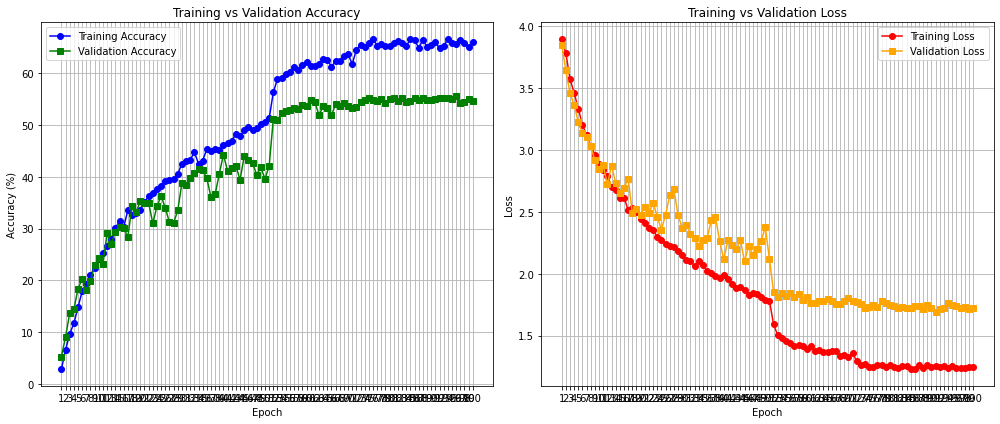

In [5]:
import torch
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous cell
# HINT: do NOT copy/paste the values. Use the variables instead
# YOUR CODE HERE 1
data_loaders =  get_data_loaders(batch_size=batch_size, valid_size=valid_size) 

# instance model MyModel with num_classes and drouput defined in the previous cell
# YOUR CODE HERE 1
model = MyModel(num_classes = num_classes, dropout = dropout) 

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
# YOUR CODE HERE 1
optimizer = get_optimizer(model=model, optimizer=opt ,learning_rate=learning_rate, weight_decay=weight_decay) 

# Get the loss using get_loss
loss = get_loss(use_cuda=True) # YOUR CODE HERE 1

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_dir="output/"
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> only run this *after* you have completed hyperpameter optimization. Do not optimize hyperparameters by looking at the results on the test set, or you might overfit on the test set (bad, bad, bad)

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [6]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE 1: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('output/best_val_loss_dict.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:19<00:00,  2.00it/s]

Test Loss: 1.572569


Test Accuracy: 60% (756/1250)


1.5725685141980652

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual, we need to complete some code!

Open `src/predictor.py` and fill up the missing code, then run the tests:

In [7]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 11.24s ==============================


Allright, now we are ready to export our model using our Predictor class:

In [9]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.3).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
# YOUR CODE HERE 1
save_dict_path = "output/best_val_loss_dict.pt"
model.load_state_dict(torch.load(save_dict_path, map_location='cpu'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor) # YOUR CODE HERE 1

scripted_predictor.save("output/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [10]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("output/original_exported.pt").cpu()  # YOUR CODE HERE 1

# Set the model to evaluation mode
model_reloaded.eval()

RecursiveScriptModule(
  original_name=Predictor
  (model): RecursiveScriptModule(
    original_name=MyModel
    (features): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(original_name=Conv2d)
      (5): RecursiveScriptModule(original_name=BatchNorm2d)
      (6): RecursiveScriptModule(original_name=LeakyReLU)
      (7): RecursiveScriptModule(original_name=MaxPool2d)
      (8): RecursiveScriptModule(original_name=Conv2d)
      (9): RecursiveScriptModule(original_name=BatchNorm2d)
      (10): RecursiveScriptModule(original_name=LeakyReLU)
      (11): RecursiveScriptModule(original_name=MaxPool2d)
      (12): RecursiveScriptModule(original_name=Conv2d)
      (13): RecursiveScriptModule(original_name=BatchNorm2d)
      (14

In [11]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [29:03<00:00,  1.39s/it]

Accuracy: 0.5528


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

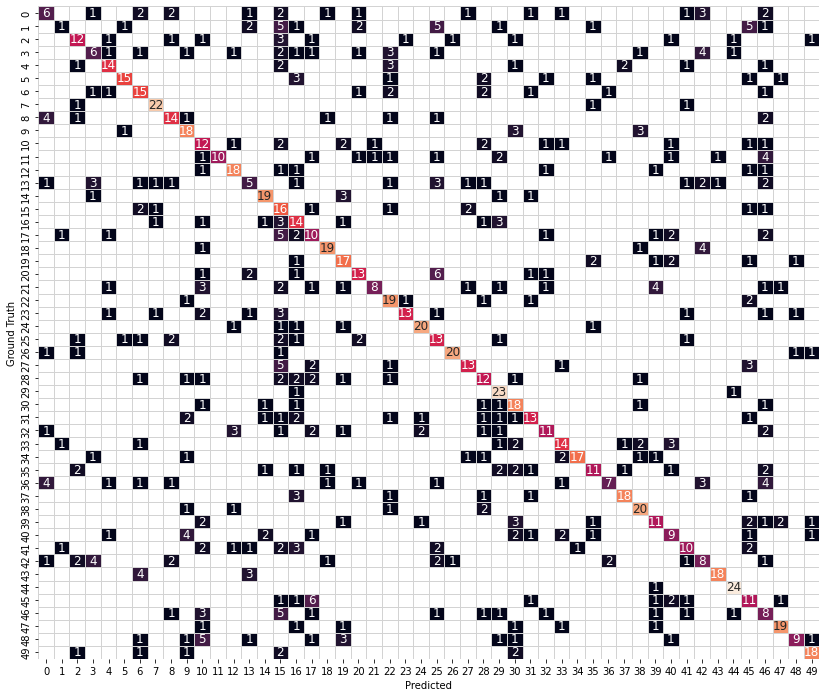

In [12]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)